In [ ]:
# Install the necessary libraries
!pip install statsmodels
!pip install tensorflow


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math

# For Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# For LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# For file download from Colab
from google.colab import files

# 1. Load data

In [ ]:
df = pd.read_csv('air_quality_cleaned.csv', parse_dates=['Datetime'], index_col='Datetime')
df = df.sort_index()
df.head()

,Record Index,CO(GT),PT08.S1(CO),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),T,RH,AH,Hour,Consumer_Timestamp,Producer_timestamp,DayOfWeek
Datetime,,,,,,,,,,,,,,,
2004-03-10 18:00:00,0,2.6,1360.0,11.9,166.0,1056.0,113.0,1692.0,13.6,48.9,0.7578,18,2025-04-04T15:26:44.422846,2025-04-04T14:45:33.903819,Wednesday
2004-03-10 19:00:00,1,2.0,1292.0,9.4,103.0,1174.0,92.0,1559.0,13.3,47.7,0.7255,19,2025-04-04T15:26:44.423620,2025-04-04T14:45:33.969644,Wednesday
2004-03-10 20:00:00,2,2.2,1402.0,9.0,131.0,1140.0,114.0,1555.0,11.9,54.0,0.7502,20,2025-04-04T15:26:44.424104,2025-04-04T14:45:33.971183,Wednesday
2004-03-10 21:00:00,3,2.2,1376.0,9.2,172.0,1092.0,122.0,1584.0,11.0,60.0,0.7867,21,2025-04-04T15:26:44.424936,2025-04-04T14:45:33.972456,Wednesday
2004-03-10 22:00:00,4,1.6,1272.0,6.5,131.0,1205.0,116.0,1490.0,11.2,59.6,0.7888,22,2025-04-04T15:26:44.425309,2025-04-04T14:45:33.973231,Wednesday


# Random Forest Model

## Feature Engineering for Random Forest

In [ ]:
# Defining a function to create features
def create_features(data):
    df_feat = data.copy()

    # Create time-based features
    df_feat['Hour'] = df_feat.index.hour
    df_feat['DayOfWeek'] = df_feat.index.dayofweek  # Monday=0, Sunday=6
    df_feat['Month'] = df_feat.index.month

    # Lag feature: previous hour's CO value
    df_feat['Lag_1_CO'] = df_feat['CO(GT)'].shift(1)

    # Rolling window: 3-hour average and standard deviation
    df_feat['RollingMean_3'] = df_feat['CO(GT)'].rolling(window=3).mean()
    df_feat['RollingStd_3'] = df_feat['CO(GT)'].rolling(window=3).std()

    # Drop rows with NaN (generated from shifting/rolling)
    df_feat.dropna(inplace=True)

    return df_feat

df_features = create_features(df)
print("\nFeature Engineered Data Sample (Random Forest):")
df_features.head()


Feature Engineered Data Sample (Random Forest):


,Record Index,CO(GT),PT08.S1(CO),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),T,RH,AH,Hour,Consumer_Timestamp,Producer_timestamp,DayOfWeek,Month,Lag_1_CO,RollingMean_3,RollingStd_3
Datetime,,,,,,,,,,,,,,,,,,,
2004-03-10 20:00:00,2,2.2,1402.0,9.0,131.0,1140.0,114.0,1555.0,11.9,54.0,0.7502,20,2025-04-04T15:26:44.424104,2025-04-04T14:45:33.971183,2,3,2.0,2.266667,0.305505
2004-03-10 21:00:00,3,2.2,1376.0,9.2,172.0,1092.0,122.0,1584.0,11.0,60.0,0.7867,21,2025-04-04T15:26:44.424936,2025-04-04T14:45:33.972456,2,3,2.2,2.133333,0.115470
2004-03-10 22:00:00,4,1.6,1272.0,6.5,131.0,1205.0,116.0,1490.0,11.2,59.6,0.7888,22,2025-04-04T15:26:44.425309,2025-04-04T14:45:33.973231,2,3,2.2,2.000000,0.346410
2004-03-10 23:00:00,5,1.2,1197.0,4.7,89.0,1337.0,96.0,1393.0,11.2,59.2,0.7848,23,2025-04-04T15:26:44.425709,2025-04-04T14:45:33.974287,2,3,1.6,1.666667,0.503322
2004-03-11 00:00:00,6,1.2,1185.0,3.6,62.0,1462.0,77.0,1333.0,11.3,56.8,0.7603,0,2025-04-04T15:26:44.425987,2025-04-04T14:45:33.975264,3,3,1.2,1.333333,0.230940


## Creating Train-test split

In [ ]:
# We create a 80-20 split for the train test
split_index = int(0.8 * len(df_features))
train_rf = df_features.iloc[:split_index]
test_rf = df_features.iloc[split_index:]

feature_cols = ['Hour', 'DayOfWeek', 'Month', 'Lag_1_CO', 'RollingMean_3', 'RollingStd_3']
target = 'CO(GT)'

X_train = train_rf[feature_cols]
y_train = train_rf[target]
X_test = test_rf[feature_cols]
y_test = test_rf[target]


## Creating baseline lag-1 prediction for CO

In [ ]:
baseline_preds = test_rf['Lag_1_CO']
baseline_mae = mean_absolute_error(y_test, baseline_preds)
baseline_rmse = math.sqrt(mean_squared_error(y_test, baseline_preds))
print("Baseline (Lag-1) MAE: {:.3f}, RMSE: {:.3f}".format(baseline_mae, baseline_rmse))

Baseline (Lag-1) MAE: 0.491, RMSE: 0.785


## Training the model

In [ ]:
# Run the training model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_preds)
rf_rmse = math.sqrt(mean_squared_error(y_test, rf_preds))
print("\nRandom Forest Model - MAE: {:.3f}, RMSE: {:.3f}".format(rf_mae, rf_rmse))


Random Forest Model - MAE: 0.226, RMSE: 0.400


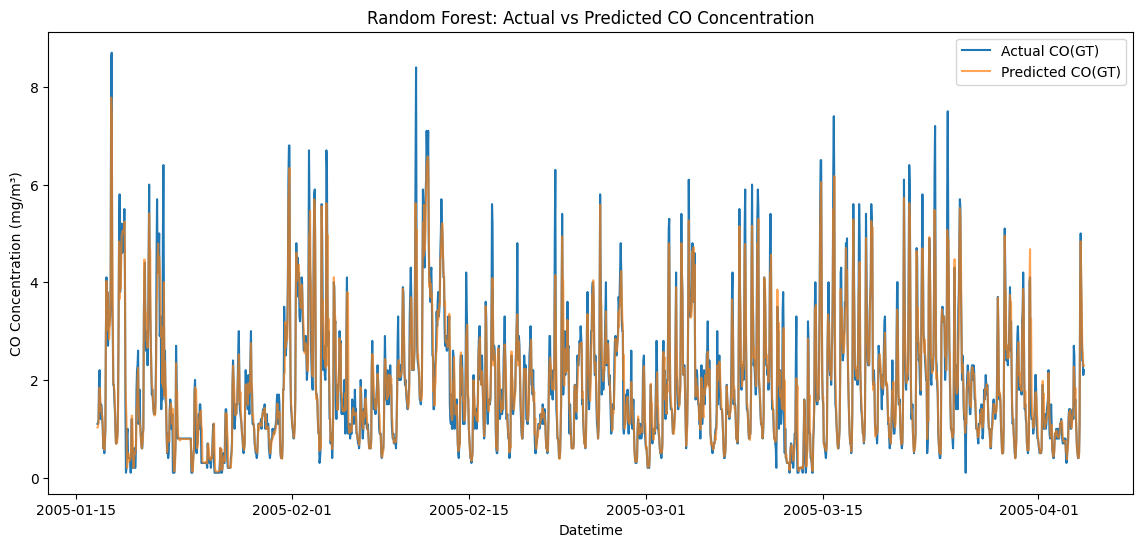

In [ ]:
#Plot the graph of actual vs predicted
plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test, label='Actual CO(GT)')
plt.plot(y_test.index, rf_preds, label='Predicted CO(GT)', alpha=0.7)
plt.xlabel('Datetime')
plt.ylabel('CO Concentration (mg/m³)')
plt.title('Random Forest: Actual vs Predicted CO Concentration')
plt.legend()
plt.show()

## Saving and downloading the model

In [ ]:
# Save the model as a pickle file
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("Random Forest model saved as rf_model.pkl")

Random Forest model saved as rf_model.pkl


In [ ]:
# Download the model
files.download('rf_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# LSTM

## Preparing and Scaling Model


In [ ]:
# Chossing the target variable as CO(GT)
# Set the frequency to hourly and filling missing values by forward-filling.
ts = df['CO(GT)'].asfreq('H').ffill()

# Reshaping the data to a 2D array for scaling
ts_values = ts.values.reshape(-1, 1)

<ipython-input-5-dfb0de781bd5>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = df['CO(GT)'].asfreq('H').ffill()


In [ ]:
# Scale the data between 0 and 1 using MinMaxScaler.
scaler = MinMaxScaler(feature_range=(0, 1))
ts_scaled = scaler.fit_transform(ts_values)

## Sequence for LSTM

In [ ]:
# Define a helper function to create input sequences and corresponding targets.
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        # Append the sequence of previous time steps as input
        X.append(data[i:i+window_size])
        # Append the value that follows the sequence as the target
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [ ]:
# window_size defines how many previous time steps are used to predict the next time step.
# We will use window_size 24
window_size = 24
X, y = create_sequences(ts_scaled, window_size)

## Split train-test

In [ ]:
# Define the split point (80% training, 20% testing)

train_size = int(0.8 * len(X))
# Split the input sequences and targets into training and testing sets.
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Build and evaluate the model

In [ ]:
# Create a Sequential model
model = Sequential()
# We add an LSTM layer with 64 units and ReLU activation.
# The input shape is (24, 1) as window_size is defined earlier
model.add(LSTM(64, activation='relu', input_shape=(window_size, 1)))
# Add a Dense layer with 1 unit as output
model.add(Dense(1))
# Compile the model with Adam optimizer and mean squared error as the loss function.
model.compile(optimizer='adam', loss='mse')


In [ ]:
# Here we will try to fit the model on the training data with validation split.
# Currently the epoch is kept as 40 and can be increased for better efficiency but then that is taking a lot of time to run
# So 40 has been found to be greatly efficient
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/65
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 2/65
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 3/65
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 4/65
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 5/65
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 6/65
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 7/65
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 8/65
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 9/65
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 10/65
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 11/65
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 12/65
210/210 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Generate predictions on the test set
predictions = model.predict(X_test)

# Inverse transform the predictions and actual target values to the original scale
predictions_inv = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
# Calculate Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE)
mae = mean_absolute_error(y_test_inv, predictions_inv)
rmse = math.sqrt(mean_squared_error(y_test_inv, predictions_inv))
print(f"LSTM MAE: {mae:.3f}, RMSE: {rmse:.3f}")

LSTM MAE: 0.395, RMSE: 0.592


## Plot the graph

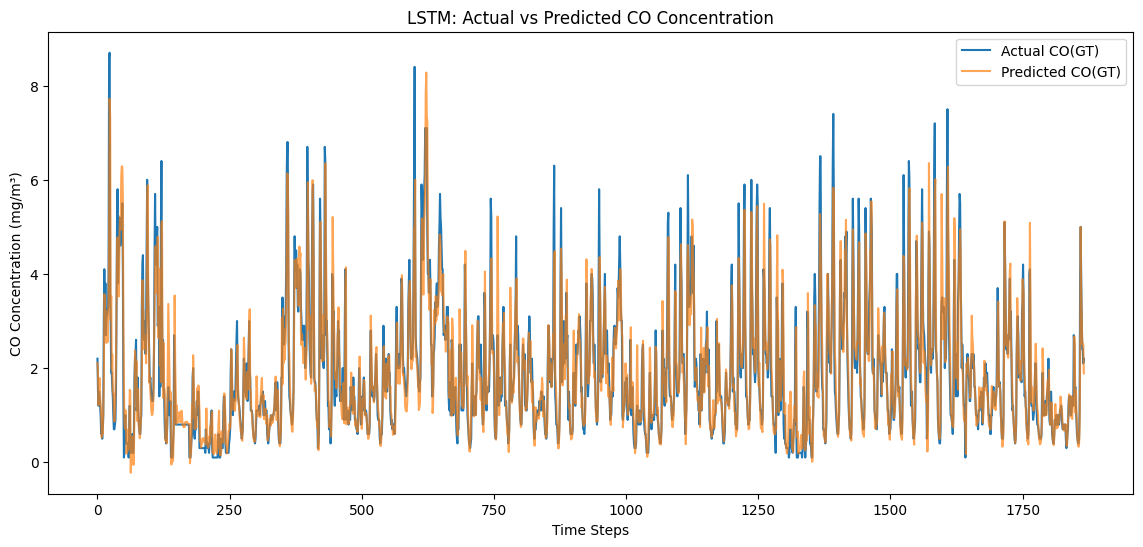

In [ ]:
# Plot the actual and predicted CO concentrations over time.
plt.figure(figsize=(14, 6))
plt.plot(y_test_inv, label='Actual CO(GT)')
plt.plot(predictions_inv, label='Predicted CO(GT)', alpha=0.7)
plt.xlabel('Time Steps')
plt.ylabel('CO Concentration (mg/m³)')
plt.title('LSTM: Actual vs Predicted CO Concentration')
plt.legend()
plt.show()

## Save & Download

In [ ]:
model.save('lstm_model.keras')
print("LSTM model saved as lstm_model.keras .")

LSTM model saved as lstm_model.keras .


In [ ]:
# Download the LSTM model file to local machine so that the consumer can use this model
files.download('lstm_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>